<div class="alert alert-info">
    <h3 align = center>NLP based Real & Fake news classifier.</h3>
    
         
    
</div>

## Importing all the necessary `libraries`

In [5]:
import pandas as pd
import openpyxl
import numpy # version == 1.26.4
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report
from spacy import displacy   
from spacy import tokenizer
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim 
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, TfidfModel
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier 
from sklearn.metrics import accuracy_score, classification_report

In [10]:
# set plot options 
plt.rcParams['figure.figsize'] = (12,8)
default_plot_color = '#007acc'

                    

#### Reading the `datset.`

In [7]:
df = pd.read_excel(r"datasets/dataset.xlsx")
df.head(4)

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


Text(0.5, 1.0, 'Data analysis of fake and factual news')

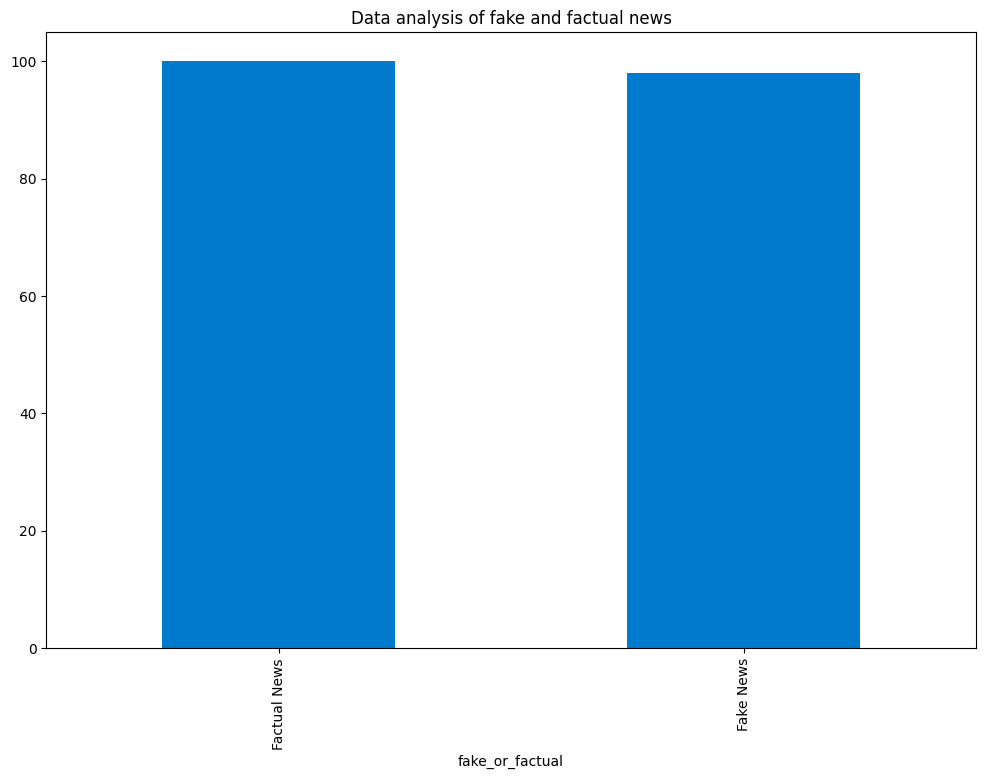

In [18]:
df['fake_or_factual'].value_counts().plot(kind='bar', color=default_plot_color)
plt.title('Data analysis of fake and factual news')

Here both the classes are almost same hence this is the perfect data set for data analysis.